In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\uzmap\appdata\local\temp\pip-req-build-nbk2rj84
  Resolved https://github.com/tensorflow/examples.git to commit fed63294c10c71b7da028e0e75de9ff68ac56d17
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\uzmap\AppData\Local\Temp\pip-req-build-nbk2rj84'


In [3]:
# import os
# os.environ["TF_DISABLE_MKL"] = "1"

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
# Define paths to image folders
trainA_dir = r"D:\CarDrivingAssistance\dataset\CycleGANShorter\trainA_balanced"  # Noisy images
trainB_dir = r"D:\CarDrivingAssistance\dataset\CycleGANShorter\trainB"  # Clear images
testA_dir = r"D:\CarDrivingAssistance\dataset\CycleGANShorter\testA"
testB_dir = r"D:\CarDrivingAssistance\dataset\CycleGANShorter\testB"

# Function to load and decode images
def load_and_decode_image(image_path):
    image = tf.io.read_file(image_path)  # Read image file
    image = tf.image.decode_png(image, channels=3)  # Decode as RGB tensor
    return image

# Function to create dataset with image tensors
def load_image_dataset(directory):
    file_paths = tf.data.Dataset.list_files(os.path.join(directory, "*.png"), shuffle=True)
    return file_paths.map(load_and_decode_image)  # Decode images

# Create tf.data datasets with image tensors
train_noisy = load_image_dataset(trainA_dir)  # Corresponds to trainA
train_clear = load_image_dataset(trainB_dir)  # Corresponds to trainB
test_noisy = load_image_dataset(testA_dir)  # Corresponds to testA
test_clear = load_image_dataset(testB_dir)  # Corresponds to testB

print("Datasets loaded successfully!")

# Debug: Print shape of one sample image
for img in train_noisy.take(1):
    print("Sample image shape:", img.shape)

Datasets loaded successfully!
Sample image shape: (1536, 2048, 3)


In [7]:
def random_crop(image):
  print("5-->", image.shape)
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  print("6-->", cropped_image.shape)
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  print("4-->", image.shape)
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  print("3-->", image.shape)
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)
  print("7-->", image.shape)
  return image

def preprocess_image_train(image):
  print("2-->", image.shape)
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  print("1-->", image.shape)
  image = normalize(image)
  return image

In [8]:
train_noisy = train_noisy.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_clear = train_clear.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_noisy = test_noisy.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_clear = test_clear.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

2--> (None, None, 3)
3--> (None, None, 3)
5--> (286, 286, 3)
6--> (256, 256, 3)
7--> (256, 256, 3)
4--> (256, 256, 3)
2--> (None, None, 3)
3--> (None, None, 3)
5--> (286, 286, 3)
6--> (256, 256, 3)
7--> (256, 256, 3)
4--> (256, 256, 3)
1--> (None, None, 3)
4--> (None, None, 3)
1--> (None, None, 3)
4--> (None, None, 3)


In [9]:
sample_noisy = next(iter(train_noisy))
sample_clear = next(iter(train_clear))

3--> (256, 256, 3)
5--> (286, 286, 3)
6--> (256, 256, 3)
7--> (256, 256, 3)


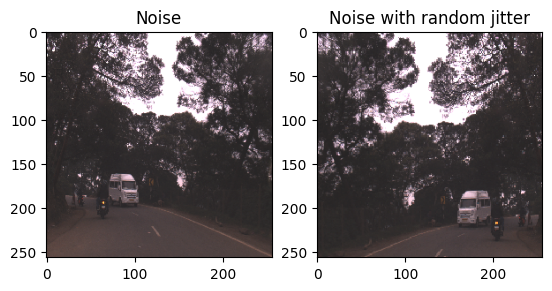

In [10]:
plt.subplot(121)
plt.title('Noise')
plt.imshow(sample_noisy[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Noise with random jitter')
plt.imshow(random_jitter(sample_noisy[0]) * 0.5 + 0.5)

3--> (256, 256, 3)
5--> (286, 286, 3)
6--> (256, 256, 3)
7--> (256, 256, 3)


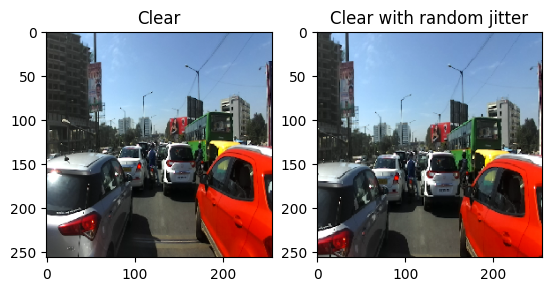

In [11]:
plt.subplot(121)
plt.title('Clear')
plt.imshow(sample_clear[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Clear with random jitter')
plt.imshow(random_jitter(sample_clear[0]) * 0.5 + 0.5)

In [12]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [13]:
print("sample_clear shape:", sample_clear.shape)

sample_clear shape: (1, 256, 256, 3)


In [14]:
print("sample_noisy shape:", sample_noisy.shape)

sample_noisy shape: (1, 256, 256, 3)


In [15]:
to_clear = generator_g(sample_noisy)
to_noisy = generator_f(sample_clear)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1895187..4.2612925].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9778523..4.0526123].


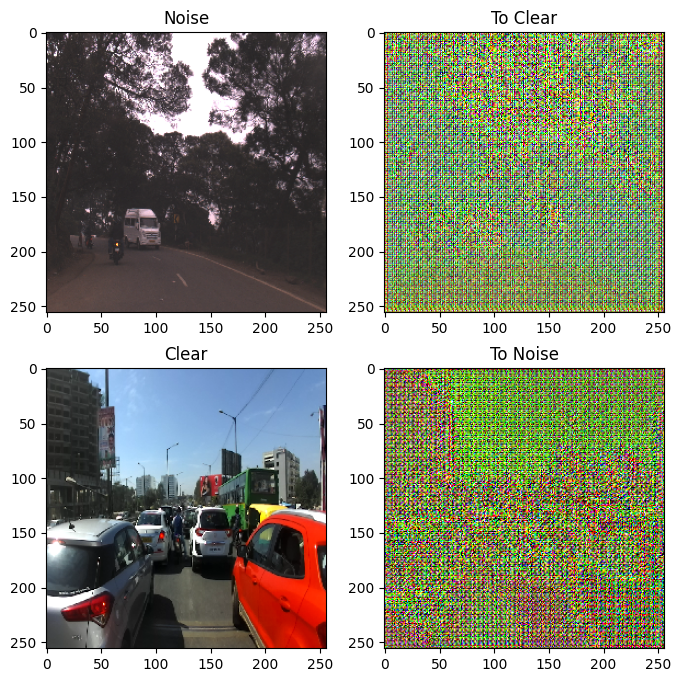

In [16]:
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_noisy, to_clear, sample_clear, to_noisy]
title = ['Noise', 'To Clear', 'Clear', 'To Noise']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
LAMBDA = 5 #changed from 10

In [18]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [20]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [21]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [22]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, clipnorm=1.0)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, clipnorm=1.0)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, clipnorm=1.0)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, clipnorm=1.0)

In [24]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 200

In [26]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [27]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

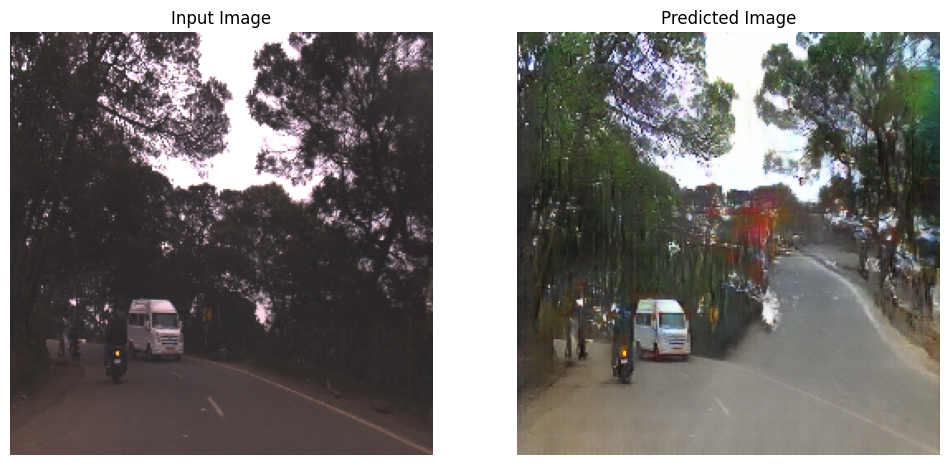

Saving checkpoint for epoch 50 at ./checkpoints/train\ckpt-14
Time taken for epoch 50 is 1845.250935792923 sec



In [28]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_noisy, train_clear)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_noise) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_noisy)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [30]:
generator_g.save('generator_g.h5')  # Noisy → Clear
generator_f.save('generator_f.h5')  # Clear → Noisy (if applicable)

print("Models saved successfully!")

Models saved successfully!


In [31]:
# Run the trained model on the test dataset
for inp in test_noisy.take(5):
  generate_images(generator_g, inp)

AbortedError: Exception encountered when calling Conv2DTranspose.call().

[1m{{function_node __wrapped____MklNativeConv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:CPU:0}} Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_input_ops.cc:546 [Op:Conv2DBackpropInput][0m

Arguments received by Conv2DTranspose.call():
  • inputs=tf.Tensor(shape=(1, 768, 1024, 128), dtype=float32)